# Meteo 515 – Assignment 1 – Exploratory Data Analysis
*Part 1 – Summary statistics and schematic plots for State College weather station data*

In [1]:
from __future__ import division
from collections import OrderedDict
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
#import statsmodels.api as sm
from statsmodels.robust.scale import mad

In [2]:
# for some interactions with figures, and sizes closer to the usual sizes
%matplotlib notebook

In the following functions, we calculate the basic statistics using their formulas, which we can compare to the results given by functions provided by Pandas, NumPy, scipy.stats, and StatsModels. 


In [3]:
def calc_median(x):
    """ """
    #x.sort_values(inplace=True)  # for pd Series; but indices follow...
    x = np.array(x)
    x.sort()
    n = x.size
    
    if n % 2 == 0:
        i1 = int(n/2)
        i2 = int((n+1)/2)
        median = (x[i1]+x[i2]) / 2
    else:
        i = int((n+1)/2)
        median = x[i]

    return median


def calc_std(x):
    """Calculate corrected sample standard deviation $s$"""
    n = x.size
    xbar = x.mean()

    ssqd = 1/(n-1)*np.sum((x-xbar)**2)
    s = np.sqrt(ssqd)

    return s

    
def calc_iqr(x):
    """Calculate IQR using fn calc_median"""
    #x.sort_values(inplace=True)
    x = np.array(x)
    x.sort()
    n = x.size
    
    if n % 2 == 0:
        i = int(n/2)
        x1 = x[:i]
        x2 = x[i:]
    else:
        i = int((n+1)/2)
        x1 = x[:i]
        x2 = x[(i-1):]

    q1 = calc_median(x1)
    q3 = calc_median(x2)

    return q3 - q1


def calc_iqr_pd(x):
    """Calculate IQR using Pandas quantile df method"""
    try:
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        return q3 - q1
    
    except AttributeError:
        print('requires pd.Series input')


def calc_mad(x):
    """Calculate median absolute deviation using fn calc_median

    MAD := the median of the absolute deviations from the data's median
    """
    #x.sort_values()
    x_median = calc_median(x)
    absdevs = np.abs(x-x_median)
    
    return calc_median(absdevs)


def calc_skew(x):
    """Calculate skewness using fn calc_std"""
    n = x.size
    xbar = x.mean()
    m3 = 1/n * np.sum( (x-xbar)**3 )  # 3rd moment
    s3 = calc_std(x)**3

    return m3/s3


def calc_YK_pd(x):
    """Calculate Yule-Kendall skewness index using Pandas quantile method"""
    try:
        q1 = x.quantile(0.25)
        q2 = x.quantile(0.5)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        return ((q3-q2)-(q2-q1)) / iqr
        
    except AttributeError:
        print('requires pd.Series input')

In [4]:
def summary_stats(x, save_table=False):
    """Descriptive stats for input np array or pd series x"""

    mean = x.mean()  # using array method (Numpy) / Series method (Pandas)
    assert(np.isclose( mean, x.sum()/x.size ))

    median = x.median()  # using array method (Numpy) / Series method (Pandas)
    assert(np.isclose( median, calc_median(x) ))

    std = x.std()  # using array method (Numpy) / Series method (Pandas)
    assert(np.isclose( std, calc_std(x) ))

    iqr = ss.iqr(x)  # using Scipy Stats
    assert(np.isclose( iqr, calc_iqr(x) ))
    assert(np.isclose( iqr, calc_iqr_pd(x) ))

    # c is a normalization constant
    # that we only need/want if we are relating MAD to the standard deviation
    #   https://en.wikipedia.org/wiki/Median_absolute_deviation#Relation_to_standard_deviation
    mad_sm = mad(x, c=1)  # using StatsModels (Pandas only has *mean* absolute dev)
    assert(np.isclose( mad_sm, calc_mad(x) ))
    
    skew = ss.skew(x)  # using Scipy Stats; Series also have skew() method
    assert(np.isclose( skew, calc_skew(x), rtol=1e-4 ))  # need a little more leeway here for some reason
    
    # found no Yule-Kendall in any Python stats packages...
    skew_yk = calc_YK_pd(x)
    
    names = ['mean', 'median', 'std', 'IQR', 'MAD', 'skewness', 'Y-K']
    varz  = [mean,   median,   std,   iqr,   mad_sm, skew, skew_yk]  # `vars` is a built-in
    d = OrderedDict([(n, v) for n, v in zip(names, varz)])
    
    return d

Now, with our ability to construct summary statistics in a table, we can proceed to the first part of the assignment.

But first we need to load the data.


In [5]:
dfname = './data/SC_data.xlsx'

convert_dateint = lambda d: pd.to_datetime(str(d))  # detects dt string format automatically

df = pd.read_excel(dfname,
    header=None, 
    #index_col=0, 
    #names=['Tmin', 'Tmax', 'PCP', '5', '6'],
    names=['date', 'Tmax', 'Tmin', 'PCP', '5', '6'],
    converters={0: convert_dateint},
    )

varnames = ['Tmax', 'Tmin', 'PCP']

## a) Schematic plot and descriptive statistics table (without dealing with missing data)

### Code to make the table and schematic plot
Note that, by default, whiskers in pyplot extend $\frac{3}{2} \mathrm{IQR}$ past the quantiles that define the edges of the box. So, we do not have adjust the settings of `whis` in our call to `boxplot`

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html

In [6]:
def make_table(dataframe, names, correct_missing=False):
    """ """
    results = {}
    for i, v in enumerate(names):
        
        if correct_missing:
            d = dataframe[v].loc[dataframe[v] != -99]
            if v == 'PCP':
                d = d.loc[d > 0]#d.loc[d != -1]
        else:
            d = dataframe[v]
            
        stats = summary_stats(d)
        
        if i == 0:  # print header
            fmt = '{:^8s}'*(len(stats)+1)
            print(fmt.format('', *stats.keys()))

        fmt = '{:^8s}' + '{:>8.3f}'*len(stats)
        print(fmt.format(v, *stats.values()))
        results[v] = stats
        
    return results


def make_schematic_plot(dataframe, names, figname='', correct_missing=False, save=False):
    """ """

    f, aa = plt.subplots(1, 3, figsize=(6, 3.5), num=figname)

    for i, v in enumerate(varnames):
        ax = aa[i]
        
        if correct_missing:
            d = dataframe[v].loc[dataframe[v] != -99]
            if v == 'PCP':
                d = d.loc[d > 0]#d.loc[d != -1]
        else:
            d = dataframe[v]

        #> style points in different regions differently
        #IQR = stats_results[v]['IQR']
        q1 = d.quantile(0.25)
        q3 = d.quantile(0.75)
        IQR = q3 - q1
        #print(v, IQR)

        far_out = (d > q3 + 3*IQR) | (d < q1 - 3*IQR)
        in_fence = ((d > q3 + 1.5*IQR) | (d < q1 - 1.5*IQR)) & ~far_out
        in_whis = ~in_fence & ~far_out

        df_v_far_out = d[far_out]
        df_v_in_fence = d[in_fence]
        df_v_in_whis = d[in_whis]

        #print(v, df_v_far_out.size)

        x = np.ones(df_v_in_whis.size)
        x = np.random.normal(1, 0.02, size=df_v_in_whis.size)
        ax.plot(x, df_v_in_whis, '.', color='0.65', ms=2, alpha=0.05)

        x = np.ones(df_v_in_fence.size)
        ax.plot(x, df_v_in_fence, '.', color='orange', ms=6, alpha=0.5)

        x = np.ones(df_v_far_out.size)
        ax.plot(x, df_v_far_out, 'r*', ms=6, alpha=0.5)

        d.plot.box(ax=ax, showfliers=False)
        #ax.boxplot(d, showfliers=False, labels=v)
        ax.grid(True)

    #aa[0].get_shared_y_axes().join(aa[0], aa[1])
    aa[1].set_ylim(ymax=aa[0].get_ylim()[1])
    aa[0].set_ylim(ymin=aa[1].get_ylim()[0])
    
    plt.tight_layout()
    
    if save:
        f.savefig('hw1p1_{:s}.pdf'.format(figname),
            transparent=True, 
            bbox_inches='tight', pad_inches=0.05,
            )

          mean   median   std     IQR     MAD   skewness  Y-K   
  Tmax    58.814  61.000  20.017  34.000  17.000  -0.430  -0.118
  Tmin    39.893  40.000  18.332  28.000  14.000  -0.993   0.071
  PCP     -0.077   0.000   0.509   0.070   0.020  -0.123   1.000


<IPython.core.display.Javascript object>


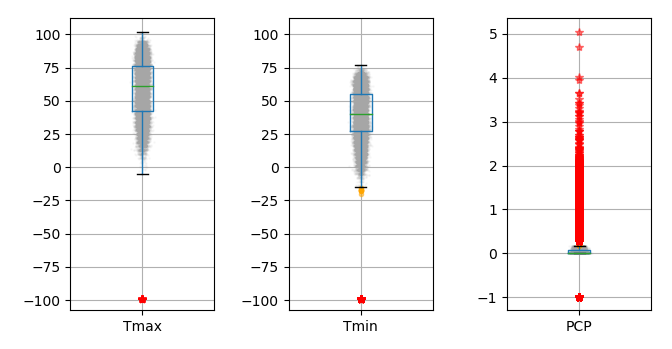

In [7]:
stats_results = make_table(df, varnames, correct_missing=False)

make_schematic_plot(df, varnames, 'schematic_plots', correct_missing=False)

## b) Repeat of a), but with missing values and trace precip values removed/ignored

          mean   median   std     IQR     MAD   skewness  Y-K   
  Tmax    58.880  61.000  19.760  34.000  17.000  -0.245  -0.118
  Tmin    40.156  40.000  17.326  28.000  14.000  -0.251   0.071
  PCP      0.282   0.140   0.369   0.340   0.120   2.907   0.412


<IPython.core.display.Javascript object>


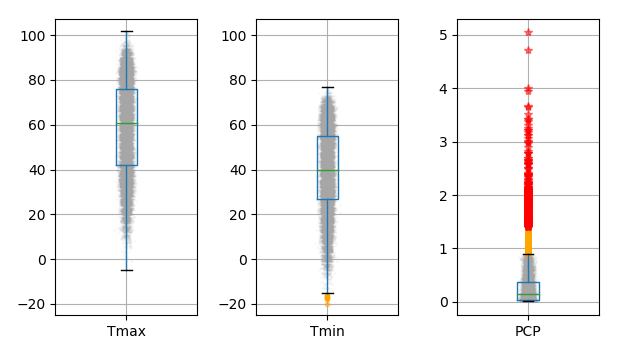

In [8]:
stats_results_2 = make_table(df, varnames, correct_missing=True)

make_schematic_plot(df, varnames, figname='schematic_plots_corrected', correct_missing=True)#, save=True)

### Influence of removing missing values and trace precip

#### Precip
On the order of 1/2 of the days in the dataset were non-precipitating, so removing that data, along with the trace precip, has a huge impact on the precip statistics. For example:

* the median is still very low compared to data in the right tail, but is now nonzero.
* the mean is now positive, as it should be to be physical


#### Temperatures
Tmax and Tmin had relatively few missing values, compared to the large proportion of missing/trace values in precip. So, the main impact of removing the missing values was to reduce the calculated measures of spread and skewness, such as standard deviation, skewness, Yule-Kendall, etc. The means received slight upward bumps, but medians showed no change. 

## c) Discussion of a) and b) results

Tmax, although it is slightly skewed left, is roughly symmetrical, so the mean is not too bad a predictor of central tendency for Tmax. Tmax has no data points that extend past the whiskers. However, with $N \sim 45000$, we would expect our sample distribution to look more symmetric if Tmax were indeed normally distributed. Thus, I would recommend median for central tendency and MAD for spread. 

Tmin has an interesting shape: the placement of the median between the quartiles suggests positive skewness, but the longer bottom whisker suggets negative skewness. Tmin has a few datapoints that extend into the lower "fence" region (with orange circle markers). Due to these attributes, I would recommend median for central tendency and MAD for spread. 

We can see in the above figure that the distribution of precip is very skewed, with a pile-up of values around 0, and a long tail extending many standard deviations to the right. Since the distribution is highly asymmetric and we have large number of outliers (in the "far-out" region, marked by red stars), we need statistics that are robust and resistant: the median for central tendency and MAD for spread. The population probably could be described by a gamma distribution with shape parameter $k < 1$.

In the histograms below, we can see that the temperatures are relatively bimodal, probably corresponding to the main winter/summer regimes.


<IPython.core.display.Javascript object>


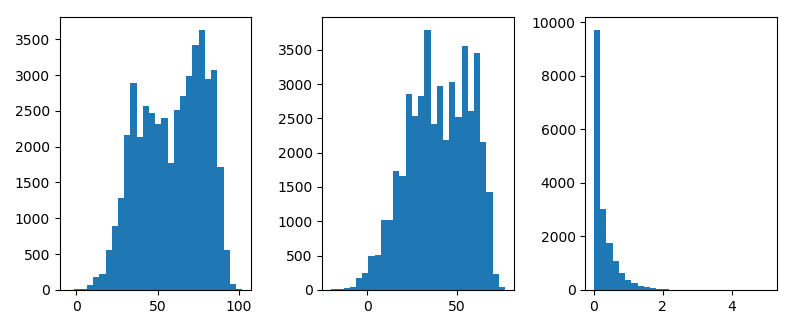

In [9]:
f, aa = plt.subplots(1, 3, figsize=(8, 3.5), num='hists')

for i, v in enumerate(varnames):
    ax = aa[i]

    # correct missing
    d = df[v].loc[df[v] != -99]
    if v == 'PCP':
        d = d.loc[d > 0]#d.loc[d != -1]

    d.hist(bins=28, ax=ax)
        
    ax.grid(False)

plt.tight_layout()

In [13]:
#> save figs
for n in plt.get_fignums():
    f = plt.figure(n)
    f.savefig('./figs/hw1p1_{:s}.png'.format(f.get_label()), dpi=300,  # too many dots in the schematic plots for good pdf
        transparent=True, 
        bbox_inches='tight', pad_inches=0.05,
        )